### Various imports

In [2]:
import torch
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor, Lambda, Compose
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

### Setting device

In [3]:
# cuda is advised, especially for training the CIFAR-10 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Loading and Transforming Datasets

In [6]:
data_transform = Compose([
    ToTensor(), # * -> Tensor
    Lambda(lambda x: (x * 2) - 1) # [0,1] -> [-1,1]
])

train_mnist = MNIST(
    root="mnist",
    train=True,
    download=True,
    transform=data_transform
)

train_cifar = CIFAR10(
    root='cifar10',
    train=True,
    download=True,
    transform=data_transform
)


batch_size = 128

dataloader_mnist = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)
dataloader_cifar = DataLoader(train_cifar, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [10]:
train_mnist[0][0].shape

torch.Size([1, 28, 28])

## Variance schedule comparison

In [5]:
from ddpm_utils import variance_schedule, forward_process
# global
T = 1000

### Figure 1

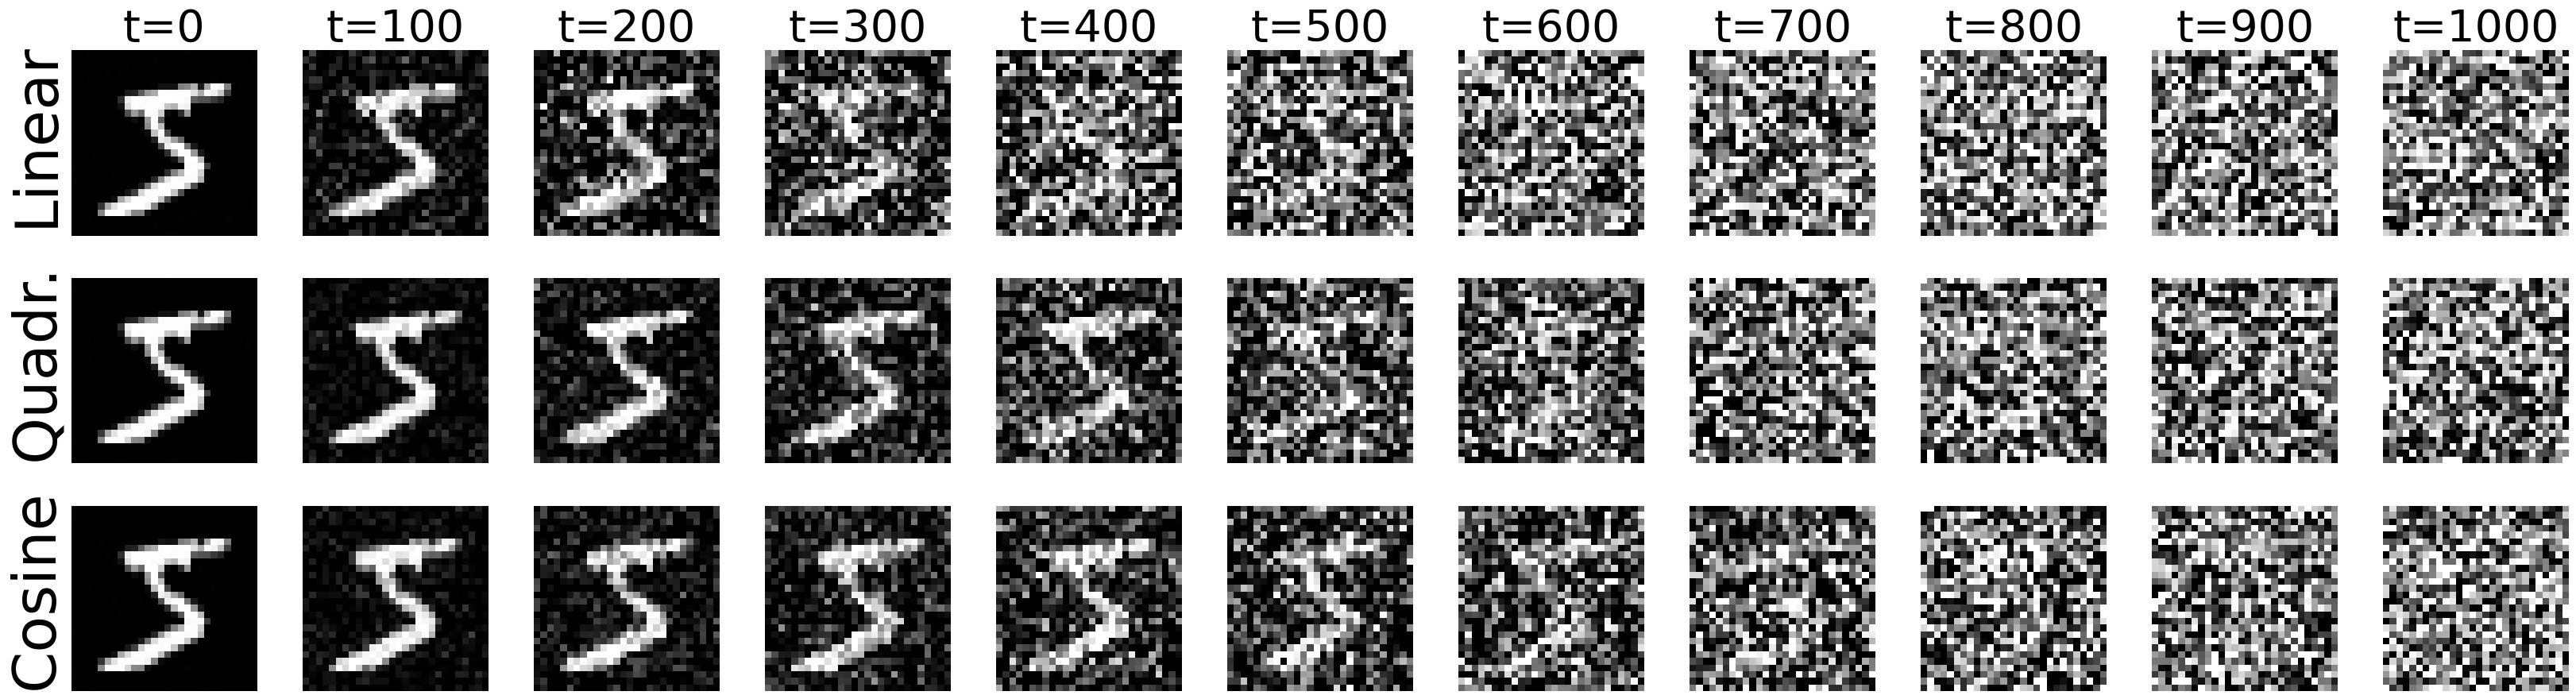

In [18]:
def viz_all_forward_processes_fixed(dataset_name, x0_index, schedules, schedule_names, num_im=9):
    ts = np.linspace(0, T - 1, num=num_im, dtype=int)
    if dataset_name=='mnist':
      cmap = 'gray'
      data = train_mnist
    elif dataset_name=='cifar10':
      data = train_cifar
      cmap = None

    x0 = data[x0_index][0].to(device)

    fig, axs = plt.subplots(len(schedules), num_im, figsize=(3 * num_im, 3 * len(schedules)))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.2)

    for row, (schedule, name) in enumerate(zip(schedules, schedule_names)):
        alpha_bar = variance_schedule(T, schedule, device)[2]
        for col, t in enumerate(ts):
            xt, _ = forward_process(x0, t, alpha_bar)

            xt_image = xt.squeeze()
            if x0.shape[0] == 3:
              xt_image = xt_image.permute(1, 2, 0)
            xt_image = xt_image.cpu()
            xt_image = torch.clamp(xt_image, min=-1.0, max=1.0)
            xt_image = (xt_image + 1.0) / 2.0

            ax = axs[row, col] if len(schedules) > 1 else axs[col]
            ax.imshow(xt_image, cmap=cmap)
            ax.axis('off')
            if row == 0:
                if t == 0:
                    ax.set_title(f"t=0", fontsize=40)
                else:
                    ax.set_title(f"t={ts[col]+1}", fontsize=40)

        # Add a subtitle for the row
        axs[row, 0].annotate(name, xy=(-0.03, 0.55), xycoords='axes fraction', fontsize=54, ha='right', va='center', rotation=90)

    plt.tight_layout()  # Adjust layout
    # plt.show()

# Example usage:
schedules = ['linear', 'quadratic', 'cosine']
schedule_names = ["Linear", "Quadr.", "Cosine"]
viz_all_forward_processes_fixed('mnist', x0_index=0, schedules=schedules, schedule_names=schedule_names, num_im=11)
# plt.savefig('forward_schedules.pdf', format='pdf', dpi=300)
plt.show()

### Figure 2

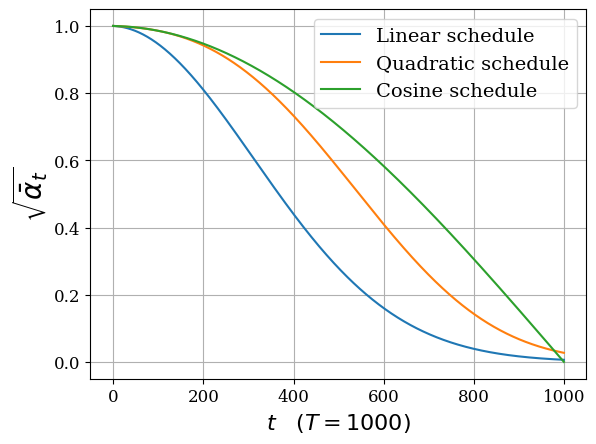

In [19]:
from matplotlib import rc
plt.rcParams.update({'font.size': 12})
# rc('text', usetex=True)
rc('font', family='serif')


beta,alpha,alpha_bar = variance_schedule(T, 'linear')
plt.plot((alpha_bar.numpy())**0.5, label='Linear schedule')

beta,alpha,alpha_bar = variance_schedule(T, 'quadratic')
plt.plot((alpha_bar.numpy())**0.5, label='Quadratic schedule')

beta,alpha,alpha_bar = variance_schedule(T, 'cosine')
plt.plot((alpha_bar.numpy())**0.5, label='Cosine schedule')

plt.ylabel(r'$\sqrt{\bar{\alpha}_t}$', fontsize=20)
plt.xlabel(r'$t$   $(T=1000)$', fontsize=16)
plt.legend(fontsize=14)
plt.grid()
# plt.savefig('alpha_bar_schedules.pdf', format='pdf', dpi=300)
plt.show()
plt.rcParams.update(plt.rcParamsDefault)

# Training

In [20]:
from ddpm_utils import train_loop, reverse_process
beta,alpha,alpha_bar = variance_schedule(T, 'cosine', device)

## MNIST

In [27]:
from nn.mnist_unet import UNet as mnist_unet
#Parameters------------------------------------------------
lr = 1e-3
n_epochs = 9
# n_epochs = 30
#Define model and optimizer
mnist_model = mnist_unet(in_channels=1, n_steps=T).to(device)
mnist_optim = torch.optim.Adam(mnist_model.parameters(), lr=lr)

In [28]:
### Load model instead of training if available

mnist_model = mnist_unet(in_channels=1, n_steps=T).to(device)
mnist_model.load_state_dict(torch.load("./mnist_cosine_model_weights.pth", weights_only=True))
mnist_model.eval()

# train_loop(dataloader_mnist, mnist_model, alpha_bar, mnist_optim, n_epochs, device)

UNet(
  (conv1): double_conv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): down_layer(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
### Save model after training
torch.save(mnist_model.state_dict(), 'mnist_cosine_model_weights.pth')

## CIFAR-10

In [29]:
from nn.labml_unet import UNet as cifar_unet
#Parameters------------------------------------------------
lr = 2e-5
n_epochs = 50
# n_epochs = 100
#Define model and optimizer
cifar_model = cifar_unet(image_channels=3, n_channels=64).to(device)
cifar_optim = torch.optim.Adam(cifar_model.parameters(), lr=lr)

In [30]:
### Load model instead of training if available

cifar_model = cifar_unet(image_channels=3, n_channels=64).to(device)
cifar_model.load_state_dict(torch.load("./cifar_cosine_model_weights.pth", weights_only=True))
cifar_model.eval()


# train_loop(dataloader_cifar, cifar_model, alpha_bar, cifar_optim, n_epochs, device)

UNet(
  (image_proj): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=64, out_features=256, bias=True)
    (act): Swish()
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down): ModuleList(
    (0-1): 2 x DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act1): Swish()
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act2): Swish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=256, out_features=64, bias=True)
        (time_act): Swish()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn): Identity()
    )
    (2): Downsample(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    

In [ ]:
### Save model after training
torch.save(cifar_model.state_dict(), 'cifar_cosine_model_weights.pth')

# Sampling

In [31]:
from ddpm_utils import sampling
from plot_utils import plot_image, grid_plot

In [37]:
@torch.no_grad()
def sample_process_plot(model, dataset_name, var_params, num_imgs, device):
    if dataset_name == 'mnist':
        img_dim = (1,28,28)
        cmap = 'gray'
    elif dataset_name == 'cifar10':
        img_dim = (3,32,32)
        cmap = None
    else:
        raise ValueError("Invalid dataset name. Either 'mnist' or 'cifar10'.")

    xT = torch.randn(size=(1,*img_dim), device=device)
    ft = xT
    model.eval()
    beta, alpha, alpha_bar = var_params
    # num_imgs = 11
    step = int(T/(num_imgs-1))
    #plt.figure(figsize=(120,10))
    fig, ax = plt.subplots(1, num_imgs, figsize=(3*num_imgs,3))
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, wspace=0.1, hspace=0.2)
    #plt.axis('off')
    for i in reversed(range(T-20)):
        t = torch.tensor([i]).to(device)
        eps_pred = model(xT,t)
        xT = reverse_process(eps_pred,t,xT,beta, alpha, alpha_bar)
        if i % step == 0:
            #fig, ax = plt.subplot(1,num_imgs+1,num_imgs-int(i/step)+1)
            img = torch.squeeze(xT)
            img = (img+1)/2
            img = torch.clamp(img, 0.0, 1.0)
            #print(images.shape)
            if dataset_name=='cifar10':
                img = img.permute(1,2,0)
            ax[num_imgs-int(i/step)-1].imshow(img.detach().cpu(), cmap=cmap)
            ax[num_imgs-int(i/step)-1].axis('off')
            t_val = np.asanyarray(t.cpu())
            ax[num_imgs-int(i/step)-1].set_title(f"t={t_val[0]}",fontsize=35)
            #plot_image(xT,True)
    img = torch.squeeze(ft)
    img = (img+1)/2
    img = torch.clamp(img, 0.0, 1.0)
    #print(images.shape)
    if dataset_name=='cifar10':
        img = img.permute(1,2,0)
    ax[0].imshow(img.detach().cpu(), cmap=cmap)
    ax[0].axis('off')
    ax[0].set_title(f"t={1000}",fontsize=35)
    return fig, ax

# ax[0].annotate("Linear", xy=(-0.03,0.55), xycoords='axes fraction', fontsize=50, ha='right', va='center', rotation=90)
# plt.tight_layout()
# plt.savefig("testcifar_linear.pdf", format="pdf",dpi=300)
# plt.show()


## MNIST

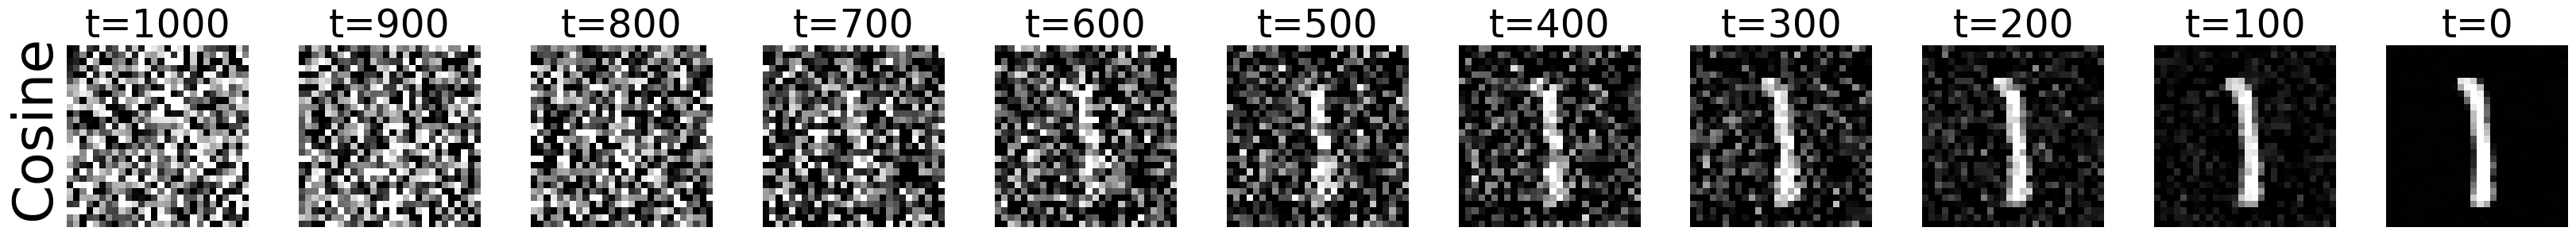

In [38]:
fig, ax = sample_process_plot(mnist_model, 'mnist', (beta,alpha,alpha_bar), 11, device)
ax[0].annotate("Cosine", xy=(-0.03,0.55), xycoords='axes fraction', fontsize=50, ha='right', va='center', rotation=90)
fig.tight_layout()
# fig.savefig("mnist_sample_cosine.pdf", format="pdf",dpi=300)
plt.show()

In [67]:
mnist_samples = sampling(mnist_model, (beta, alpha, alpha_bar),
                         device=device, dataset_name='mnist', batch_size=3*3)

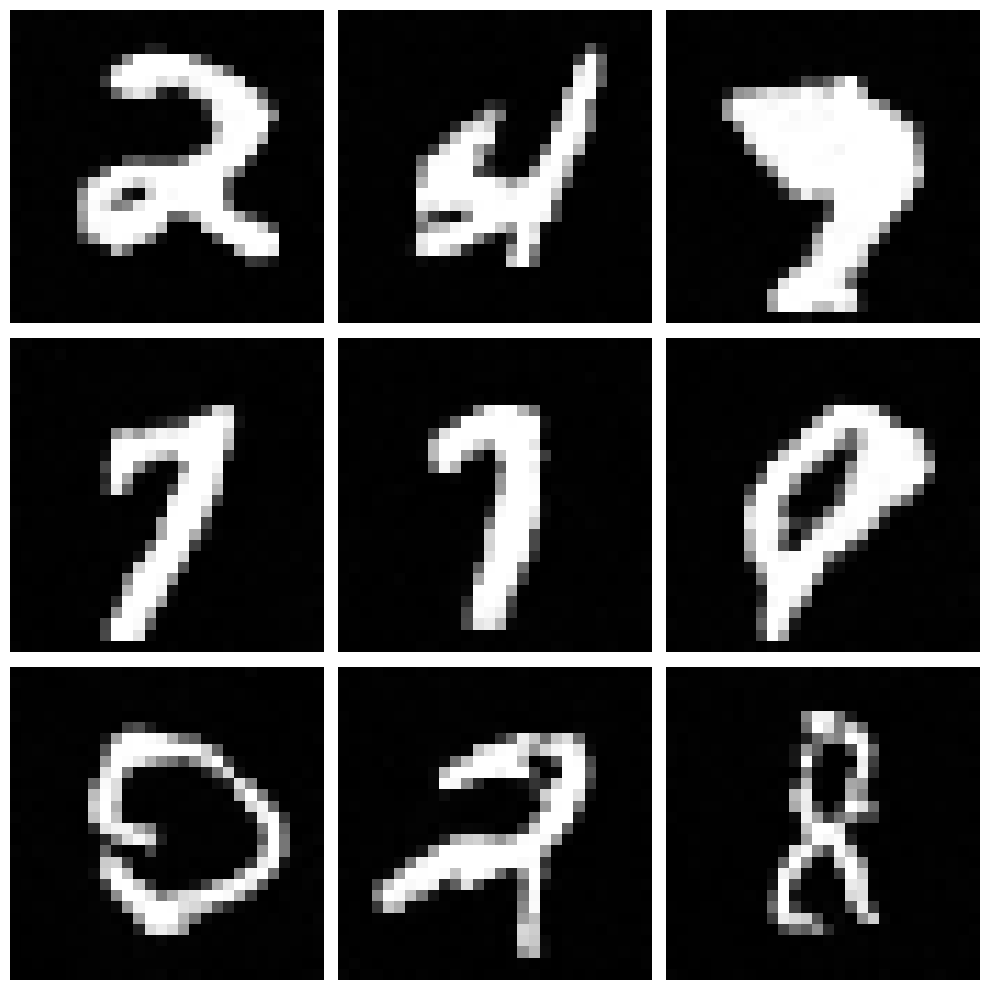

In [68]:
grid_plot(mnist_samples, (3,3), (10,10))
plt.show()

## CIFAR-10

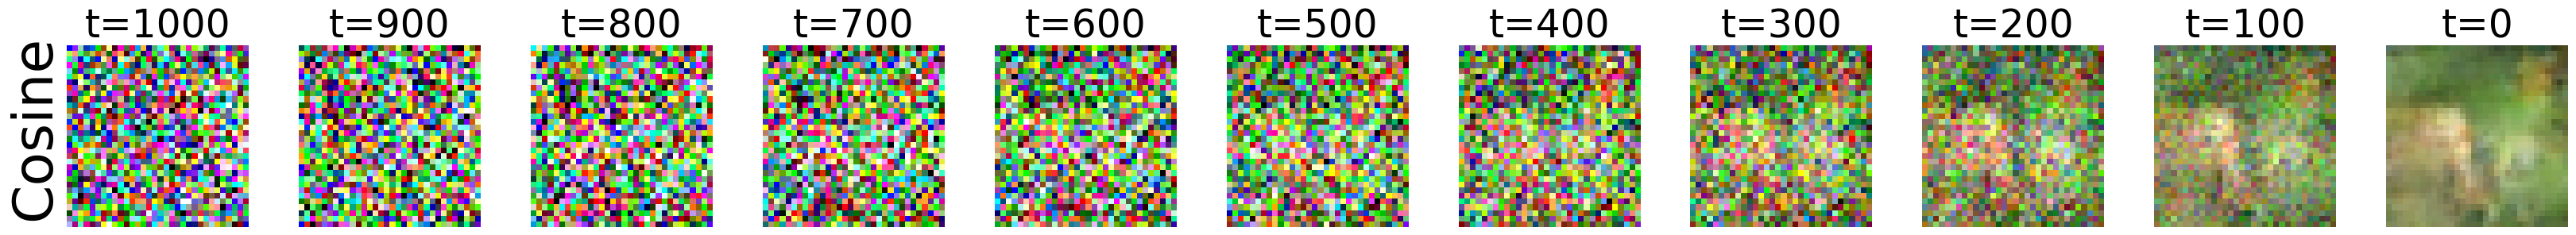

In [39]:
fig, ax = sample_process_plot(cifar_model, 'cifar10', (beta,alpha,alpha_bar), 11, device)
ax[0].annotate("Cosine", xy=(-0.03,0.55), xycoords='axes fraction', fontsize=50, ha='right', va='center', rotation=90)
fig.tight_layout()
# fig.savefig("cifar_sample_cosine.pdf", format="pdf",dpi=300)
plt.show()

In [63]:
cifar_samples = sampling(cifar_model, (beta, alpha, alpha_bar),
                         device=device, dataset_name='cifar10', batch_size=3*3)


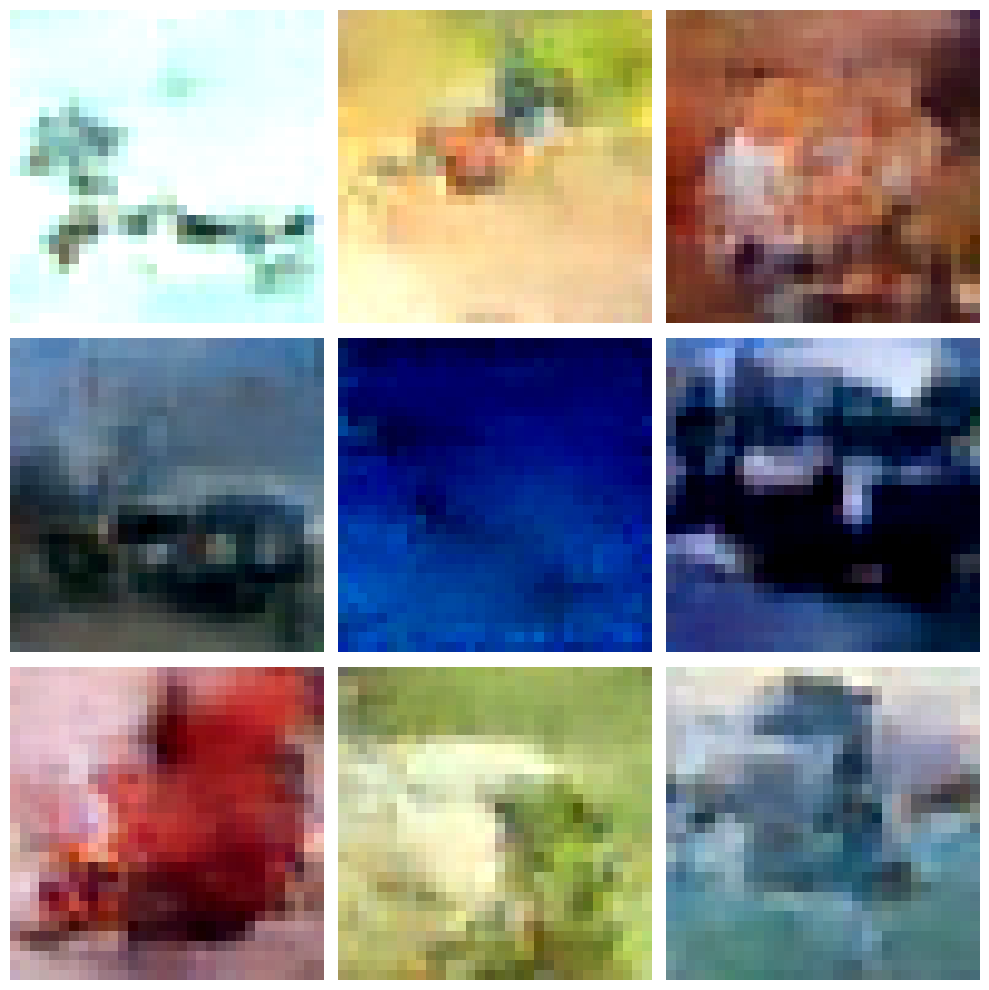

In [64]:
grid_plot(cifar_samples, (3,3), (10,10))
plt.show()

# FID Score

In [82]:
import os
from nn.labml_unet import UNet as cifar_unet

from ddpm_utils import variance_schedule, generate_samples_todir

In [74]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar_model = cifar_unet(image_channels=3, n_channels=64).to(device)
cifar_model.load_state_dict(torch.load("./cifar_cosine_model_weights.pth", weights_only=True))
cifar_model.eval()

UNet(
  (image_proj): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=64, out_features=256, bias=True)
    (act): Swish()
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down): ModuleList(
    (0-1): 2 x DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act1): Swish()
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act2): Swish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=256, out_features=64, bias=True)
        (time_act): Swish()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn): Identity()
    )
    (2): Downsample(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    

In [72]:
T = 1000
beta, alpha, alpha_bar = variance_schedule(T, 'cosine', device)

In [84]:
#Sample images and save them in a folder for FID calculations
# Directory to save generated samples
output_dir = "generated_samples_GOOD/epoch_cosine/"
os.makedirs(output_dir, exist_ok=True)

#We have used 3000 since it takes a lot of time to sample however increasing the number of samples yields more accurate FID calculations
generate_samples_todir(
    model=cifar_model,
    dataset_name='cifar10',
    output_dir=output_dir,
    var_params=(beta, alpha, alpha_bar),
    num_samples=3000,
    batch_size=100
)

  0%|          | 0/30 [00:00<?, ?it/s]

0


  3%|▎         | 1/30 [04:43<2:17:04, 283.62s/it]


KeyboardInterrupt: 

In [ ]:
#We calculate FID by using the pip package
#pip install pytorch-fid
#Github repo: https://github.com/mseitzer/pytorch-fid
#One can calculate the FID by running the following command in the console:
#python -m pytorch_fid path/to/dataset1 path/to/dataset2

#Make sure to have both the samples saved in a folder and the cifar/mnist saved in a folder